In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_csv(filename):
    csv_path = os.path.join(labels_path, filename)
    return pd.read_csv(csv_path)

In [ ]:
def extract_patches(roi, height, width, length):
    #patches = np.zeros((length, patch_size, 3), dtype = np.float32)
    patches = np.zeros((length, patch_size, patch_size, 3), dtype = np.float32)
    patch_iter = 0
    for i in range(0, height - patch_size + 1):
        for j in range(0, width - patch_size + 1):
            #patches[patch_iter : patch_iter + patch_size, :, :] = roi[i : i + patch_size, j : j + patch_size, :]
            patches[patch_iter, :, :, :] = roi[i : i + patch_size, j : j + patch_size, :]
            #patch_iter += patch_size
            patch_iter += 1
    return patches

In [ ]:
def process_rois(filename, folder, count):
    roi_data = load_csv(filename)
    originals_folder = os.path.join(originals_path, folder)
    labels_folder = os.path.join(labels_path, folder)
    
#     np.random.seed(42)
#     roi_data = roi_data.iloc[np.random.permutation(len(roi_data))]

    N_patches = sum((roi_data['height'] - patch_size + 1) 
                    * (roi_data['width'] - patch_size + 1))
    rois = np.zeros((N_patches, patch_size, patch_size, 3), dtype = np.float32)
    skeletons = np.zeros((N_patches, 1), dtype = np.float32)

    roi_iter = 0
    skelet_iter = 0
    for index, row in roi_data.iterrows():
        img = plt.imread(originals_folder + row['label'] + '.tif')
        height = row['height']
        width = row['width']
        patches_per_roi = (height - patch_size + 1) * (width - patch_size + 1)
        #length = patch_size * patches_per_roi
        length = patches_per_roi
#         rois[roi_iter : roi_iter + length, :, :] = extract_patches(img[row['ycoord'] :
#                                                                        row['ycoord'] + height, 
#                                                                        row['xcoord'] : 
#                                                                        row['xcoord'] + width, :],
#                                                                    height, width, length)
        rois[roi_iter : roi_iter + length, :, :, :] = extract_patches(img[row['ycoord'] :
                                                                       row['ycoord'] + height, 
                                                                       row['xcoord'] : 
                                                                       row['xcoord'] + width, :],
                                                                   height, width, length)
        roi_iter += length
        
        img = plt.imread(labels_folder + row['label'] + '_' + str(row['sample']) + '_' + 'skeletone.jpg')
        img_grey = np.dot(img[...,:3], [0.299, 0.587, 0.114])
        skeletons[skelet_iter : skelet_iter + patches_per_roi] = img_grey[d : height - d, 
                                                                          d : width - d].reshape(-1, 1)

        skelet_iter += patches_per_roi
        
    labels[count : count + N_patches] = skeletons
    #originals[count * patch_size : count * patch_size + N_patches * patch_size, :, :] = rois
    originals[count : count + N_patches, :, :, :] = rois
    count += N_patches
    return originals, labels, count



## Load the data, extract originals and labels

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import load_data
start_time = time.time()

originals, labels, count = load_data.process_rois('CS8_ROIs.csv', 'cellsuspensionED8/', 0)
print('count = ', count)

print("--- %s seconds ---" % (time.time() - start_time))



In [ ]:
labels = labels[:count, :]
print('labels shape: ', labels.shape)
#originals = originals[:count * patch_size, :, :]
originals = originals[: count, :, :, :]
print('originals shape: ', originals.shape)

In [ ]:
i = 0
plt.figure(figsize=(15, 10))
plt.subplot(141)
plt.imshow(originals[i, :, :, 1], cmap = plt.cm.gray, interpolation = "nearest")
plt.subplot(142)
plt.imshow(originals[i+1, :, :, 1], cmap = plt.cm.gray, interpolation = "nearest")
plt.subplot(143)
plt.imshow(originals[i+2, :, :, 1], cmap = plt.cm.gray, interpolation = "nearest")
plt.subplot(144)
plt.imshow(originals[i+3, :, :, 1], cmap = plt.cm.gray, interpolation = "nearest")

plt.figure(figsize=(15, 10))
plt.subplot(141)
plt.imshow(originals[i+4, :, :, 1], cmap = plt.cm.gray, interpolation = "nearest")
plt.subplot(142)
plt.imshow(originals[i+5, :, :, 1], cmap = plt.cm.gray, interpolation = "nearest")
plt.subplot(143)
plt.imshow(originals[i+6, :, :, 1], cmap = plt.cm.gray, interpolation = "nearest")
plt.subplot(144)
plt.imshow(originals[i+7, :, :, 1], cmap = plt.cm.gray, interpolation = "nearest")
plt.show()
print(originals[i:i+8, 11, 11, 1])
labels[i:i+8]

In [ ]:
i = 2000
plt.figure(figsize=(15, 10))
plt.subplot(141)
plt.imshow(originals[i, :, :, 1], cmap = plt.cm.gray, interpolation = "nearest")
plt.subplot(142)
plt.imshow(originals[i+1, :, :, 1], cmap = plt.cm.gray, interpolation = "nearest")
plt.subplot(143)
plt.imshow(originals[i+2, :, :, 1], cmap = plt.cm.gray, interpolation = "nearest")
plt.subplot(144)
plt.imshow(originals[i+3, :, :, 1], cmap = plt.cm.gray, interpolation = "nearest")

plt.figure(figsize=(15, 10))
plt.subplot(141)
plt.imshow(originals[i+4, :, :, 1], cmap = plt.cm.gray, interpolation = "nearest")
plt.subplot(142)
plt.imshow(originals[i+5, :, :, 1], cmap = plt.cm.gray, interpolation = "nearest")
plt.subplot(143)
plt.imshow(originals[i+6, :, :, 1], cmap = plt.cm.gray, interpolation = "nearest")
plt.subplot(144)
plt.imshow(originals[i+7, :, :, 1], cmap = plt.cm.gray, interpolation = "nearest")
plt.show()
print(originals[i:i+8, 11, 11, 1])
labels[i:i+8]

## Evaluate the data

In [ ]:
plt.hist(labels, bins = 255)
plt.show()

In [ ]:
# Create binary labels
# TRUE if it's a vessel, otherwise FALSE
binary_labels = 1 * (labels < 128) + 0 * (labels >= 128)
print(binary_labels.shape)
print(binary_labels[:8])
plt.hist(binary_labels, bins = 2)
plt.show()

In [ ]:
#n_neg = int(sum(binary_labels[:, 1]))
n_pos = int(sum(binary_labels))
n_neg = count - n_pos
print('Number of negative samples: ', n_neg)
print('Number of positive samples: ', n_pos)
print('Fraction of positive samples: ', n_pos / count * 100, '%')
new_ratio = 1
n_neg_new = int(new_ratio * n_pos)
print('Need to randomly choose ', n_neg_new, ' negative samples to make it', new_ratio, ': 1')

## Reduce the number of negative samples

In [ ]:
#neg_indeces = (np.where(binary_labels[:, 1] == 1))[0]
neg_indeces = (np.where(binary_labels == 0))[0]
np.random.shuffle(neg_indeces)
neg_indeces_new = neg_indeces[:n_neg_new]

## Create stratified training and test sets

In [ ]:
train_ratio = 0.8
n_samples = n_pos + n_neg_new

print(n_samples, n_pos, n_neg_new)
print('train: ', round(train_ratio * n_samples), ', test: ', round((1 - train_ratio) * n_samples))
print('Positive. y_train: ', round(train_ratio * n_pos), ', y_test: ', round((1 - train_ratio) * n_pos))
print('Negative. y_train: ', round(train_ratio * n_neg_new), ', y_test: ', round((1 - train_ratio) * n_neg_new))

In [ ]:
#pos_indeces = (np.where(binary_labels[:, 0] == 1))[0]
pos_indeces = (np.where(binary_labels == 1))[0]
np.random.shuffle(pos_indeces)
pos_indeces_train = pos_indeces[:round(train_ratio * n_pos)]
pos_indeces_test = pos_indeces[round(train_ratio * n_pos):]

neg_indeces_train = neg_indeces_new[:round(train_ratio * n_neg_new)]
neg_indeces_test = neg_indeces_new[round(train_ratio * n_neg_new):]

In [ ]:
train_indeces = np.append(pos_indeces_train, neg_indeces_train, axis=0)
np.random.shuffle(train_indeces)
X_train = originals[train_indeces, :, :, :]
#y_train = labels[train_indeces]
y_train = binary_labels[train_indeces]

test_indeces = np.append(pos_indeces_test, neg_indeces_test, axis = 0)
np.random.shuffle(test_indeces)
X_test = originals[test_indeces, :, :, :]
#y_test = labels[test_indeces]
y_test = binary_labels[test_indeces]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train.dtype

In [ ]:
X_train_small = X_train[:100, :, :, :]
y_train_small = y_train[:100, :]
print(X_train_small.shape, y_train_small.shape)
print(y_train_small.sum())

## CNN

In [4]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # Angio images are 23x23 pixels, and have three color channels
    input_layer = tf.reshape(features["x"], [-1, 23, 23, 3])
    print('input_layer: ', input_layer.shape)
    
    # Convolutional Layer #1
    # Computes 32 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 23, 23, 1]
    # Output Tensor Shape: [batch_size, 23, 23, 32]
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    print('conv1: ', conv1.shape)

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 23, 23, 32]
    # Output Tensor Shape: [batch_size, 11, 11, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    print('pool1: ', pool1.shape)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 11, 11, 32]
  # Output Tensor Shape: [batch_size, 11, 11, 64]
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    print('conv2: ', conv2.shape)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 11, 11, 64]
  # Output Tensor Shape: [batch_size, 5, 5, 64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    print('pool2: ', pool2.shape)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 5, 5, 64]
  # Output Tensor Shape: [batch_size, 5 * 5 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 5 * 5 * 64])
    print('pool2_flat: ', pool2_flat.shape)

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 5 * 5 * 64]
  # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 2]
    logits = tf.layers.dense(inputs=dropout, units=2)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels = labels, predictions=predictions["classes"]),
        "precision": tf.metrics.precision(
            labels = labels, predictions = predictions["classes"]),
        "recall": tf.metrics.recall(
            labels = labels, predictions = predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)    

## Train the model

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

count =  883402
--- 16.668571949005127 seconds ---
labels shape:  (883402, 1)
originals shape:  (883402, 23, 23, 3)


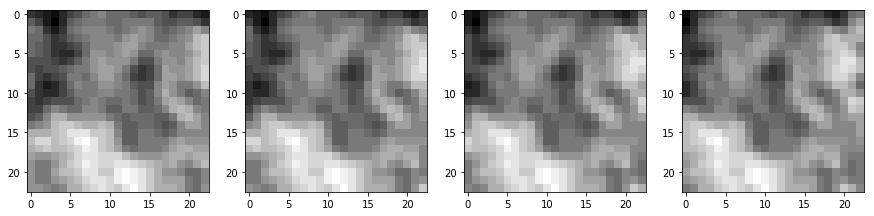

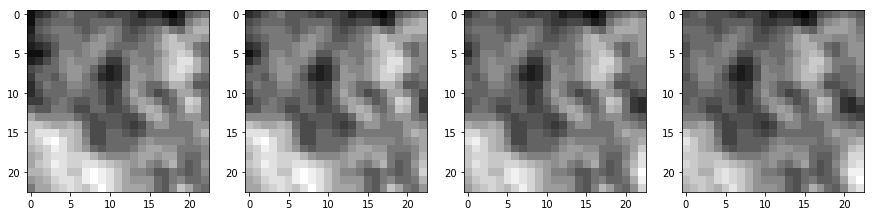

[150. 151. 150. 148. 149. 151. 154. 155.]


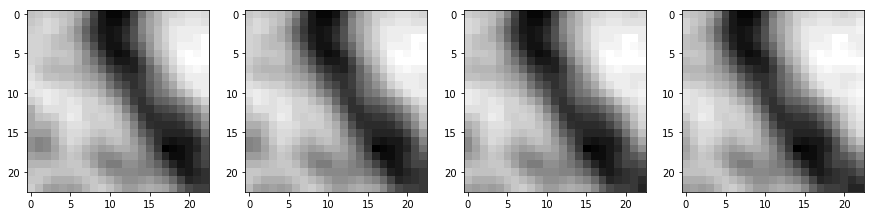

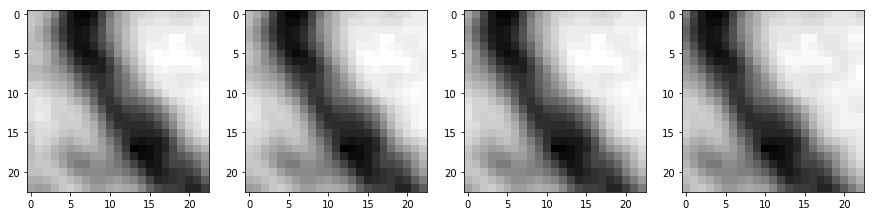

[154. 147. 140. 138. 141. 145. 146. 148.]


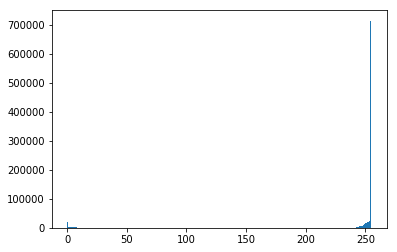

(883402, 1)
[[0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]]


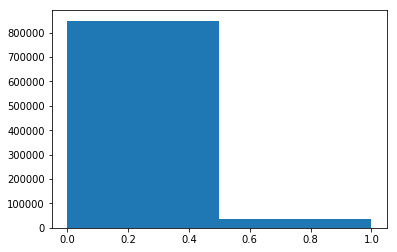

Number of negative samples:  848583
Number of positive samples:  34819
Fraction of positive samples:  3.941467191606992 %
Need to randomly choose  34819  negative samples to make it 1 : 1
69638 34819 34819
train:  55710 , test:  13928
Positive. y_train:  27855 , y_test:  6964
Negative. y_train:  27855 , y_test:  6964
(55710, 23, 23, 3) (55710, 1)
(13928, 23, 23, 3) (13928, 1)
(100, 23, 23, 3) (100, 1)
48


In [2]:
# Load angio data
%run angio_data.ipynb

In [5]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/angio_convnet_model")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=500)

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train_small},
    y=y_train_small,
    #x={"x": train_data},
    #y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=1000,
    hooks=[logging_hook])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/angio_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x19890cd160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
input_layer:  (100, 23, 23, 3)
conv1:  (100, 23, 23, 32)
pool1:  (100, 11, 11, 32)
conv2:  (100, 11, 11, 64)
pool2:  (100, 5, 5, 64)
pool2_flat:  (100, 1600)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tenso

In [ ]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_test},
    y=y_test,
    #x={"x": eval_data},
    #y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)